In [1]:
from molmap import loadmap
from molmap import dataset
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Concatenate,Flatten, Dense, Dropout

%matplotlib inline
#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

seed = 777
np.random.seed(seed)
tf.set_random_seed(seed)


def Inception(inputs, units = 8, strides = 1):
    """
    naive google inception block
    """
    x1 = Conv2D(units, 5, padding='same', activation = 'relu', strides = strides)(inputs)
    x2 = Conv2D(units, 3, padding='same', activation = 'relu', strides = strides)(inputs)
    x3 = Conv2D(units, 1, padding='same', activation = 'relu', strides = strides)(inputs)
    outputs = Concatenate()([x1, x2, x3])    
    return outputs

    
def SinglePathClassificationModel(molmap_shape,  n_outputs = 1, strides = 1):
    """molmap_shape: w, h, c"""
    
    assert len(molmap_shape) == 3
    inputs = Input(molmap_shape)
    
    conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(inputs)
    
    conv1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(conv1) #p1
    
    incept1 = Inception(conv1, strides = 1, units = 32)
    
    incept1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(incept1) #p2
    
    incept2 = Inception(incept1, strides = 1, units = 64)
    
    #flatten
    flat1 = GlobalMaxPool2D()(incept2)   
    d1 = Dense(128,activation='tanh')(flat1)
    d1 = Dense(64,activation='tanh')(d1)
    
    outputs = Dense(n_outputs,activation='linear')(d1)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env

In [2]:
def get_deepchem_idx(df):
    """ deepchem dataset"""
    deepchem_data_name = './ESOL_deepchem.data'
    if os.path.exists(deepchem_data_name):
        train_df,valid_df,test_df = load(deepchem_data_name)
    else:
        import deepchem as dc
        task, train_valid_test, _ = dc.molnet.load_delaney(featurizer='Raw', split='random')
        train, valid, test = train_valid_test
        print('training set: %s, valid set: %s, test set %s' % (len(train.ids), len(valid.ids), len(test.ids)))
        train_df = df[df.smiles.isin(train.ids)]
        valid_df = df[df.smiles.isin(valid.ids)]
        test_df = df[df.smiles.isin(test.ids)]
        dump((train_df,valid_df,test_df), deepchem_data_name)
    train_idx = train_df.index
    valid_idx = valid_df.index
    test_idx = test_df.index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx


def get_attentiveFP_idx(df):
    """ attentiveFP dataset"""
    train, valid,test = load('./ESOL_attentiveFP.data')
    print('training set: %s, valid set: %s, test set %s' % (len(train), len(valid), len(test)))
    train_idx = df[df.smiles.isin(train.smiles)].index
    valid_idx = df[df.smiles.isin(valid.smiles)].index
    test_idx = df[df.smiles.isin(test.smiles)].index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx 

In [3]:
data = dataset.load_ESOL()
df = data.data
Y = data.y

total samples: 1128


In [4]:
train_idx, valid_idx, test_idx = get_deepchem_idx(df) #random seed has no effects

len(train_idx), len(valid_idx), len(test_idx)

training set: 902, valid set: 113, test set 113


(902, 113, 113)

In [5]:
# calculate feature
X1_name =  './X_descriptor.data'
X2_name =  './X_fingerprint.data'

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp1 = loadmap('../../descriptor_grid_split.mp')
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
    
if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    mp2 = loadmap('../../fingerprint_grid_split.mp')
    X2 = mp2.batch_transform(df.smiles, n_jobs = 8)
    dump(X2, X2_name)

In [6]:
trainX = X1[train_idx]
trainY = Y[train_idx]

validX = X1[valid_idx]
validY = Y[valid_idx]

testX = X1[test_idx]
testY = Y[test_idx]

# import deepchem as dc
# task, train_valid_test, _ = dc.molnet.load_delaney(featurizer='Raw', split='random')
# train, valid, test = train_valid_test

# trainX = mp1.batch_transform(train.ids, n_jobs = 8)
# trainY = train.y

# validX = mp1.batch_transform(valid.ids, n_jobs = 8)
# validY = valid.y

# testX = mp1.batch_transform(test.ids, n_jobs = 8)
# testY = test.y

In [7]:
from cbks import RegressionPerformance, EarlyStoppingAtMinLoss
molmap1_size = X1.shape[1:]
model = SinglePathClassificationModel(molmap1_size, n_outputs = Y.shape[1])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
earlystop = EarlyStoppingAtMinLoss(patience=30, criteria = 'val_loss')
performace = RegressionPerformance((trainX, trainY), (validX, validY))
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = lr, loss = 'mse')

In [9]:
model.fit(trainX, trainY, batch_size=128, 
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performace, earlystop]) 

epoch: 0001, loss: 8.1484 - val_loss: 5.6910; rmse: 2.2064 - rmse_val: 2.3856;  r2: 0.2913 - r2_val: 0.1941                                                                                                    
epoch: 0002, loss: 4.4345 - val_loss: 4.3540; rmse: 2.1068 - rmse_val: 2.0866;  r2: 0.3835 - r2_val: 0.3112                                                                                                    
epoch: 0003, loss: 4.4850 - val_loss: 4.3143; rmse: 2.0883 - rmse_val: 2.0771;  r2: 0.4314 - r2_val: 0.3697                                                                                                    
epoch: 0004, loss: 4.2500 - val_loss: 4.4492; rmse: 2.0406 - rmse_val: 2.1093;  r2: 0.4548 - r2_val: 0.4119                                                                                                    
epoch: 0005, loss: 4.1798 - val_loss: 4.5838; rmse: 2.0390 - rmse_val: 2.1410;  r2: 0.4565 - r2_val: 0.4268                                                             

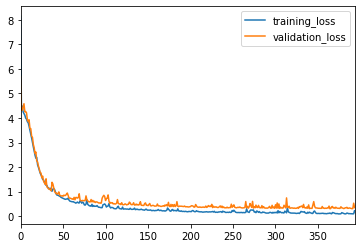

In [10]:
dfp = pd.DataFrame(performace.history)[['training_loss', 'validation_loss']]
dfp.plot()

In [11]:
performace.evaluate(trainX, trainY) # RMSE, R^2

([0.30747200398875063], [0.9783658527417857])

In [12]:
performace.evaluate(validX, validY) # RMSE, R^2

([0.5506743247613348], [0.932089925743214])

In [13]:
performace.evaluate(testX, testY) # RMSE, R^2

([0.5176859998059472], [0.9459196013510949])

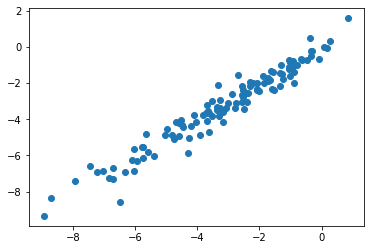

In [14]:
plt.scatter(performace.model.predict(testX), testY)